<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20221111.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Analysis
* Iterator

In [1]:
import pandas as pd 
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes
import matplotlib.pyplot as plt 
import seaborn as sns 
from datetime import datetime, date, time, timezone, timedelta 

import os
import re

from functools import reduce
from collections import defaultdict

import prophet as pr

# Customer Analysis

In [2]:
os.listdir()

['.config',
 'online_retail.xlsx',
 '1_customers_dataset.csv',
 'ecommerce-data.csv',
 'test.csv',
 'mall_customers.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'KPMG_VI_New_raw_data_update_final.csv',
 'sample-sales-data.csv',
 'bz_data_analyis.csv',
 'groceries.csv',
 'sales_data_with_stores.csv',
 '1_order_payments_dataset.csv',
 'online_retail_II.xlsx',
 'scanner_data.csv',
 'sales_vs_discount.csv',
 'sales.csv',
 '1_orders_dataset.csv',
 'match_result_test.csv',
 'mock_sales_data.csv',
 'sample_data']

In [5]:
df = pd.read_csv('bz_data_analyis.csv')
df.order_date = pd.to_datetime(df.order_date, infer_datetime_format=True)
df['date'] = df.order_date.to_numpy().astype('datetime64[D]')
df['week'] = df['date'] - df['date'].dt.weekday.astype('timedelta64[D]')
#df['rev'] = df.quantity_ordered * df.price_each
df.head()

,customer_id,product,quantity_ordered,price_each,purchase_address,month,year,day,city,code,sales,order_date,hour,minute,count,date,week
0,295665,Macbook Pro Laptop,1,1700.00,"136 Church St, New York City, NY 10001",12,2019,30,New York City (NY),NY,1700.00,2019-12-30 00:01:00,0,1,1,2019-12-30,2019-12-30
1,295666,LG Washing Machine,3,600.00,"562 2nd St, New York City, NY 10001",12,2019,29,New York City (NY),NY,600.00,2019-12-29 07:03:00,7,3,1,2019-12-29,2019-12-23
2,295667,USB-C Charging Cable,3,11.95,"277 Main St, New York City, NY 10001",12,2019,12,New York City (NY),NY,11.95,2019-12-12 18:21:00,18,21,1,2019-12-12,2019-12-09
3,295668,27in FHD Monitor,2,149.99,"410 6th St, San Francisco, CA 94016",12,2019,22,San Francisco (CA),CA,149.99,2019-12-22 15:13:00,15,13,1,2019-12-22,2019-12-16
4,295669,USB-C Charging Cable,1,11.95,"43 Hill St, Atlanta, GA 30301",12,2019,18,Atlanta (GA),GA,11.95,2019-12-18 12:38:00,12,38,1,2019-12-18,2019-12-16


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185950 entries, 0 to 185949
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   customer_id       185950 non-null  int64         
 1   product           185950 non-null  object        
 2   quantity_ordered  185950 non-null  object        
 3   price_each        185950 non-null  float64       
 4   purchase_address  185950 non-null  object        
 5   month             185950 non-null  int64         
 6   year              185950 non-null  int64         
 7   day               185950 non-null  int64         
 8   city              185950 non-null  object        
 9   code              185950 non-null  object        
 10  sales             185950 non-null  float64       
 11  order_date        185950 non-null  datetime64[ns]
 12  hour              185950 non-null  int64         
 13  minute            185950 non-null  int64         
 14  coun

In [8]:
df.quantity_ordered.value_counts()

1          109128
1           59357
2            8663
2            4707
3            1867
3            1066
4             529
4             280
5             152
5              86
6              49
6              31
7              18
7               6
8               5
9               3
1+C1273         1
32              1
22              1
Name: quantity_ordered, dtype: int64

In [13]:
df['quantity_ordered'] = df['quantity_ordered'].apply(lambda x : np.where(x == '1+C1273', '1', x))
df['quantity_ordered'] = df['quantity_ordered'].astype(int)
df['quantity_ordered'].value_counts()

1     168486
2      13370
3       2933
4        809
5        238
6         80
7         24
8          5
9          3
32         1
22         1
Name: quantity_ordered, dtype: int64

In [14]:
df['rev'] = df['quantity_ordered'] * df['price_each']
df.head()

,customer_id,product,quantity_ordered,price_each,purchase_address,month,year,day,city,code,sales,order_date,hour,minute,count,date,week,rev
0,295665,Macbook Pro Laptop,1,1700.00,"136 Church St, New York City, NY 10001",12,2019,30,New York City (NY),NY,1700.00,2019-12-30 00:01:00,0,1,1,2019-12-30,2019-12-30,1700.00
1,295666,LG Washing Machine,3,600.00,"562 2nd St, New York City, NY 10001",12,2019,29,New York City (NY),NY,600.00,2019-12-29 07:03:00,7,3,1,2019-12-29,2019-12-23,1800.00
2,295667,USB-C Charging Cable,3,11.95,"277 Main St, New York City, NY 10001",12,2019,12,New York City (NY),NY,11.95,2019-12-12 18:21:00,18,21,1,2019-12-12,2019-12-09,35.85
3,295668,27in FHD Monitor,2,149.99,"410 6th St, San Francisco, CA 94016",12,2019,22,San Francisco (CA),CA,149.99,2019-12-22 15:13:00,15,13,1,2019-12-22,2019-12-16,299.98
4,295669,USB-C Charging Cable,1,11.95,"43 Hill St, Atlanta, GA 30301",12,2019,18,Atlanta (GA),GA,11.95,2019-12-18 12:38:00,12,38,1,2019-12-18,2019-12-16,11.95


In [21]:
list_product = df['product'].value_counts().reset_index().rename(columns = {'index':'product', 'product':'cnt'})
list_product['type'] = ['cable', 'cable', 'batteries', 'batteries', 'headphones', 'headphones', 'headphones',
                        'monitor', 'mobile', 'monitor', 'monitor', 'mobile', 'tv', 'laptop', 'laptop',
                        'monitor', 'mobile', 'whites', 'whites'
                        ]

get_product = dict(zip(list_product['product'], list_product['type']))
list_product.head()


,product,cnt,type
0,USB-C Charging Cable,21903,cable
1,Lightning Charging Cable,21658,cable
2,AAA Batteries (4-pack),20641,batteries
3,AA Batteries (4-pack),20577,batteries
4,Wired Headphones,18882,headphones


In [22]:
df['type'] = df['product'].apply(lambda x : get_product.get(x, x))
df.head()

,customer_id,product,quantity_ordered,price_each,purchase_address,month,year,day,city,code,sales,order_date,hour,minute,count,date,week,rev,type
0,295665,Macbook Pro Laptop,1,1700.00,"136 Church St, New York City, NY 10001",12,2019,30,New York City (NY),NY,1700.00,2019-12-30 00:01:00,0,1,1,2019-12-30,2019-12-30,1700.00,laptop
1,295666,LG Washing Machine,3,600.00,"562 2nd St, New York City, NY 10001",12,2019,29,New York City (NY),NY,600.00,2019-12-29 07:03:00,7,3,1,2019-12-29,2019-12-23,1800.00,whites
2,295667,USB-C Charging Cable,3,11.95,"277 Main St, New York City, NY 10001",12,2019,12,New York City (NY),NY,11.95,2019-12-12 18:21:00,18,21,1,2019-12-12,2019-12-09,35.85,cable
3,295668,27in FHD Monitor,2,149.99,"410 6th St, San Francisco, CA 94016",12,2019,22,San Francisco (CA),CA,149.99,2019-12-22 15:13:00,15,13,1,2019-12-22,2019-12-16,299.98,monitor
4,295669,USB-C Charging Cable,1,11.95,"43 Hill St, Atlanta, GA 30301",12,2019,18,Atlanta (GA),GA,11.95,2019-12-18 12:38:00,12,38,1,2019-12-18,2019-12-16,11.95,cable


In [25]:
cnt_sales = df.groupby(['date','type'])['quantity_ordered'].count().reset_index().rename(columns = {'date':'ds', 'quantity_ordered':'y'})
cnt_sales.head()

,ds,type,y
0,2019-01-01,batteries,66
1,2019-01-01,cable,76
2,2019-01-01,headphones,63
3,2019-01-01,laptop,18
4,2019-01-01,mobile,30


In [52]:
def get_pr(df) :

  list_worker = list_product['type']

  plts = list()

  for worker in list_worker :

    working = cnt_sales[cnt_sales['type'] == worker]

    m = pr.Prophet().fit(working[['ds', 'y']])
    future = m.make_future_dataframe(periods = 60)
    forecast = m.predict(future)

    x = m.plot(forecast)
    plts.append(x)
  
  wow = dict(list_worker, plts)

  return wow

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz1axtvd7/qvvq0b0e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz1axtvd7/6eizvizg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3145', 'data', 'file=/tmp/tmpz1axtvd7/qvvq0b0e.json', 'init=/tmp/tmpz1axtvd7/6eizvizg.json', 'output', 'file=/tmp/tmpz1axtvd7/prophet_modelrg8xdunr/prophet_model-20221110233817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:38:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:38:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality.

TypeError: ignored

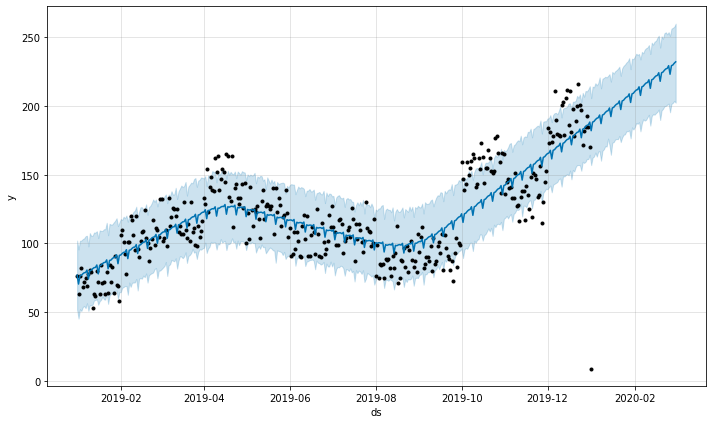

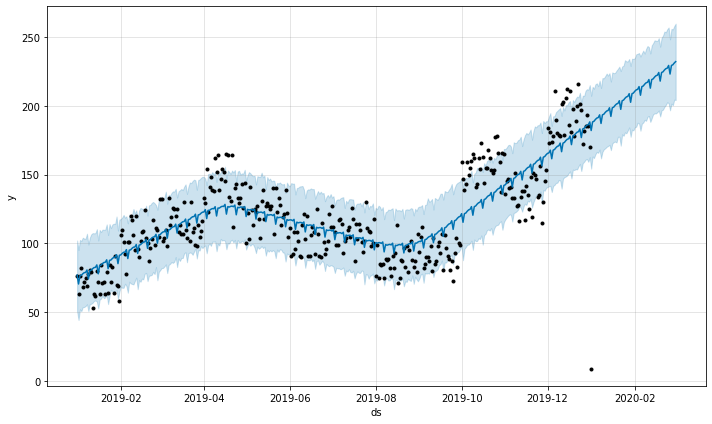

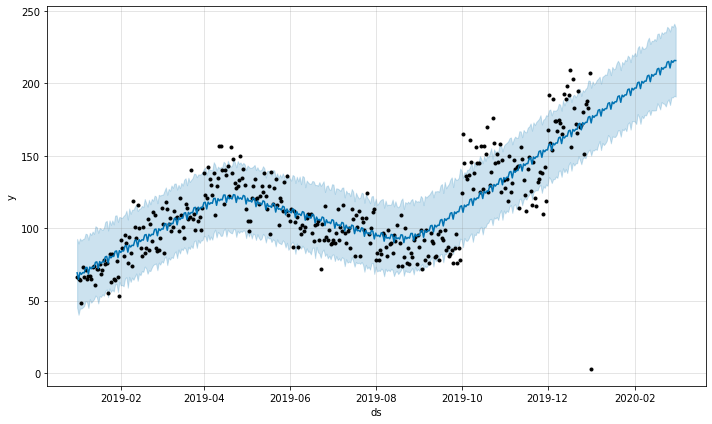

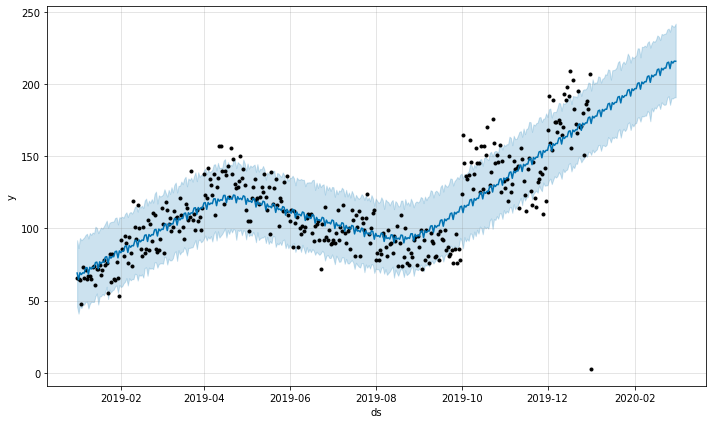

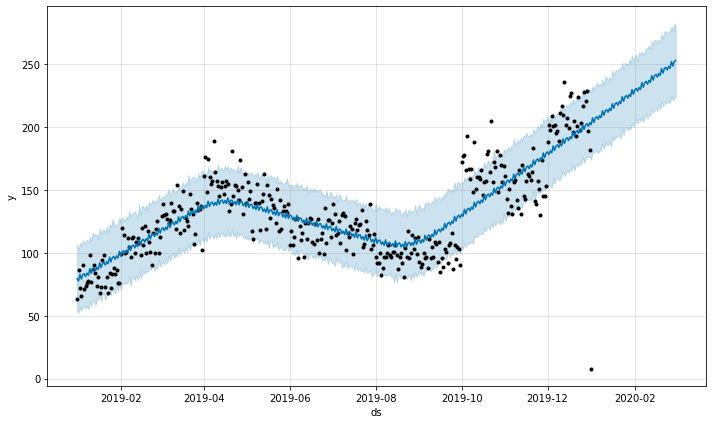

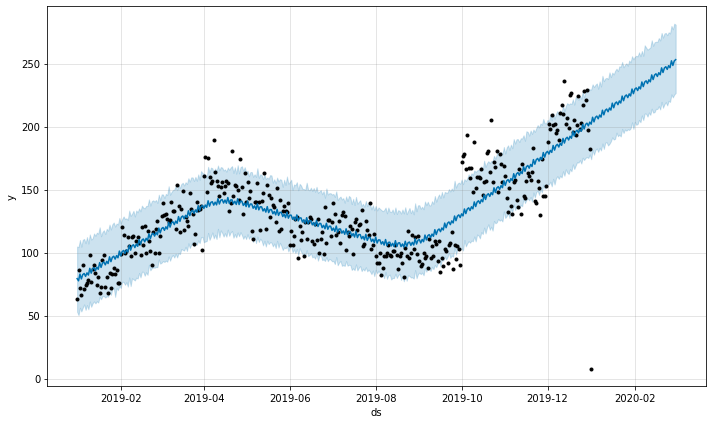

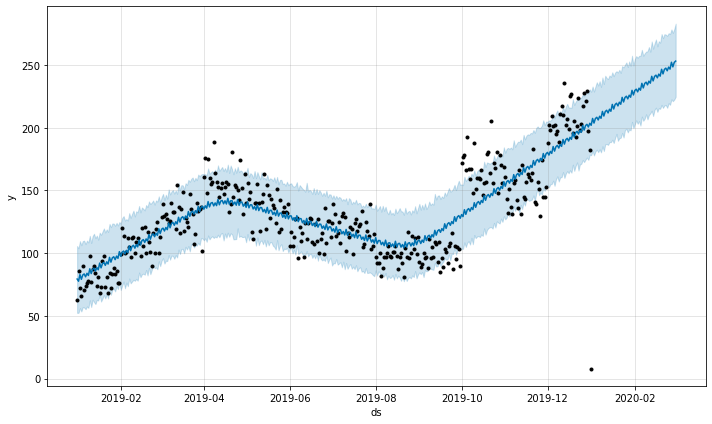

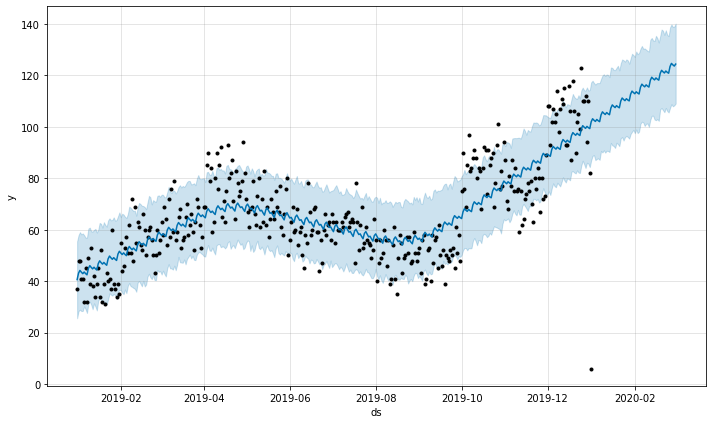

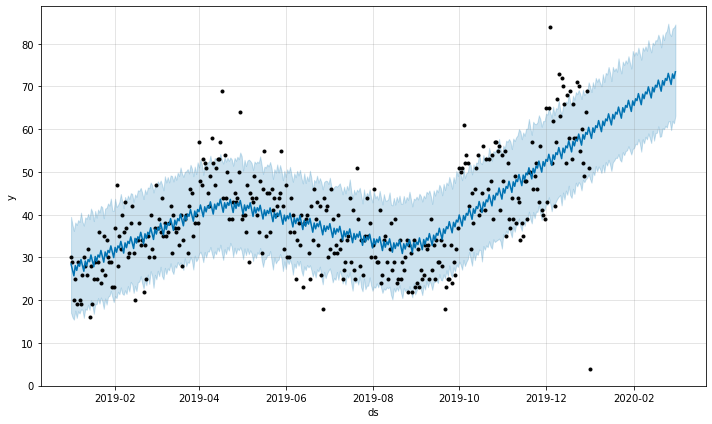

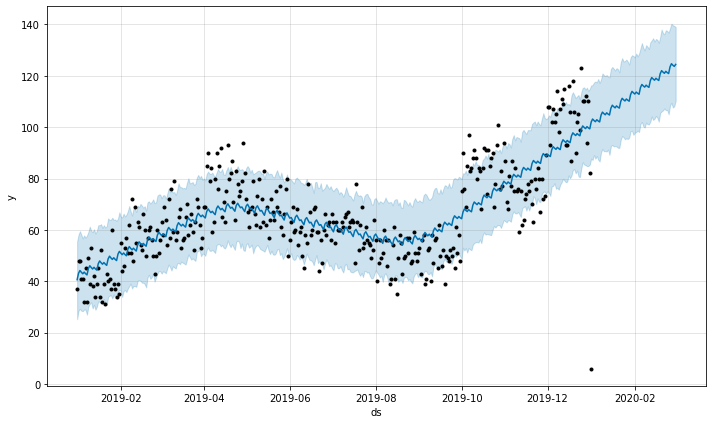

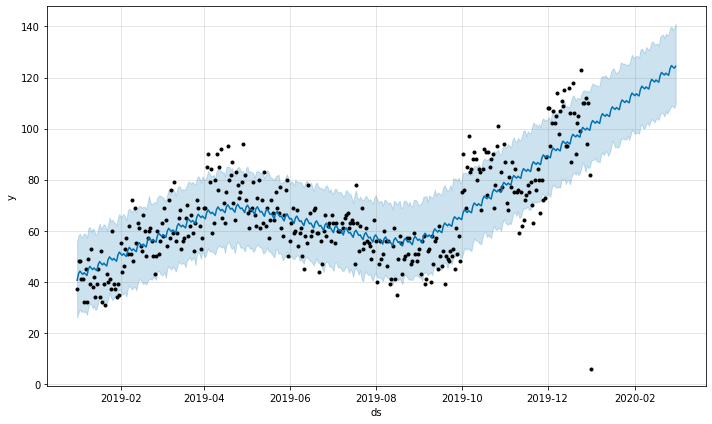

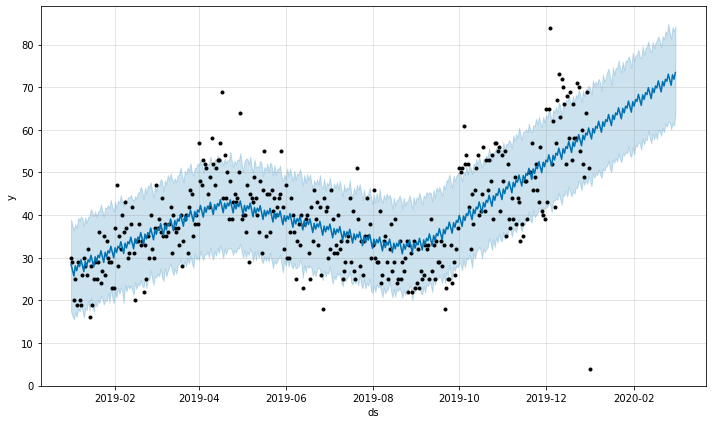

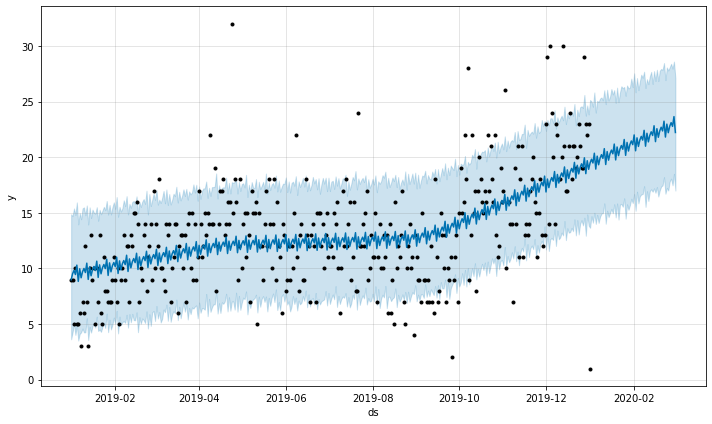

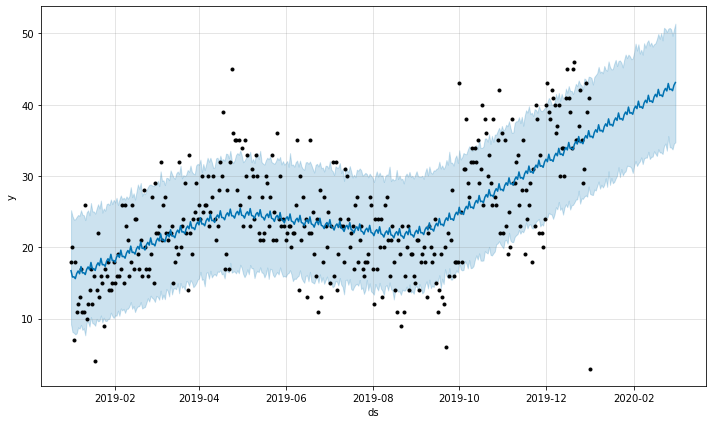

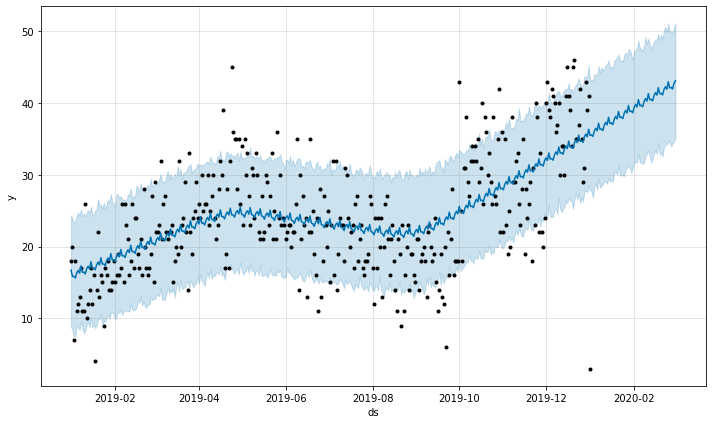

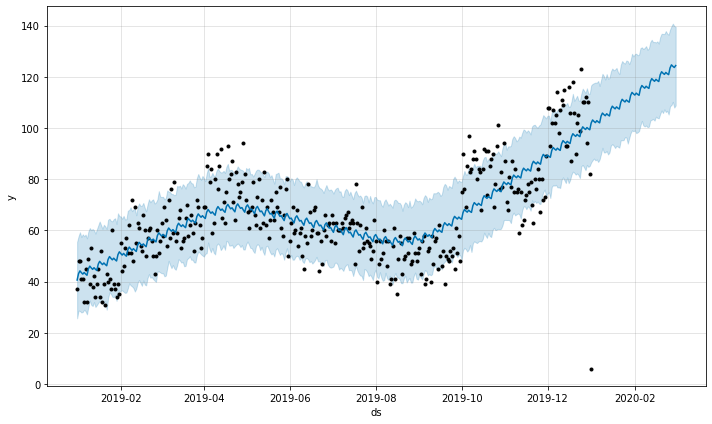

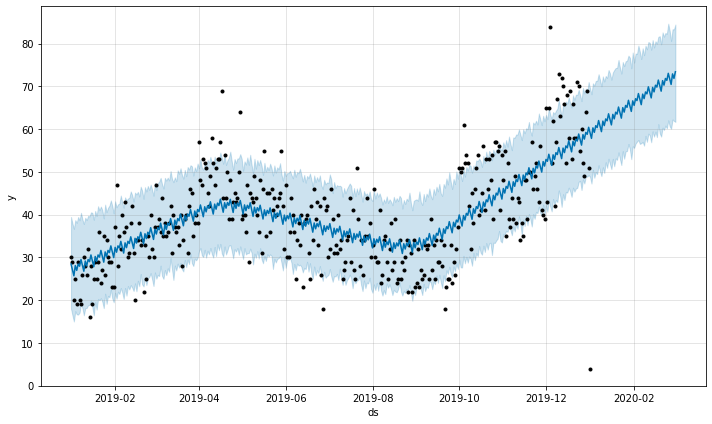

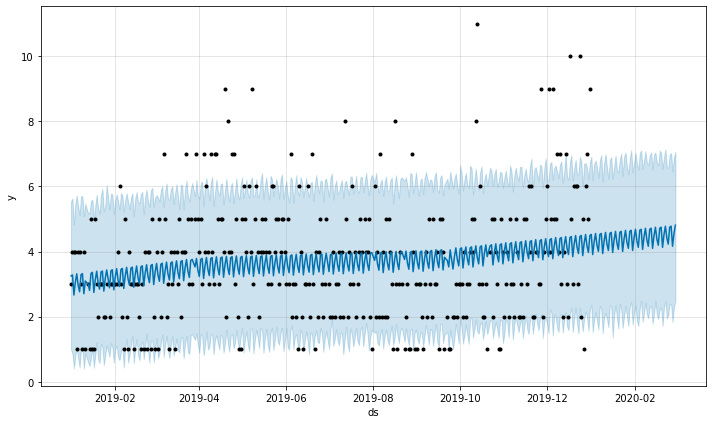

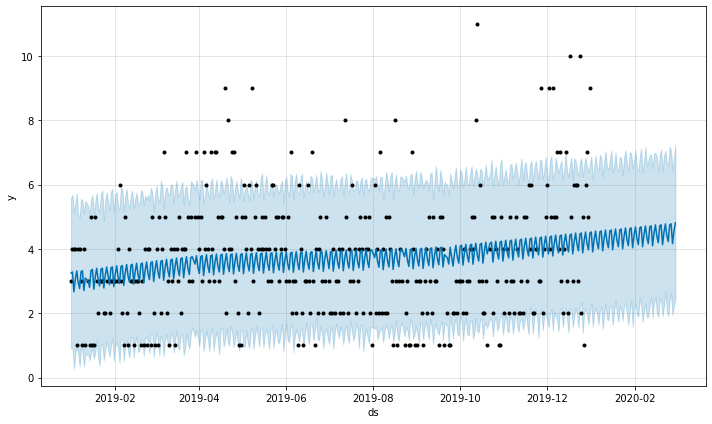

In [53]:
pr = get_pr(df)
pr

# Iterator

In [58]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [59]:
{k : eval(f'reduce(lambda acc, cur : acc + [cur["{k}"]], users, [])') for k in list(users[0].keys())}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}